# Data Wrangling and EDA
*** 
**The goal of this project is to isolate three specific surfaces of an overhead crane rail:**

* Top of the rail head – the flat surface where the crane wheel runs.
* Side of the rail head – the vertical face just below the top.
* Side of the rail web – the vertical face of the thinner section connecting the head to the base.<br><br>

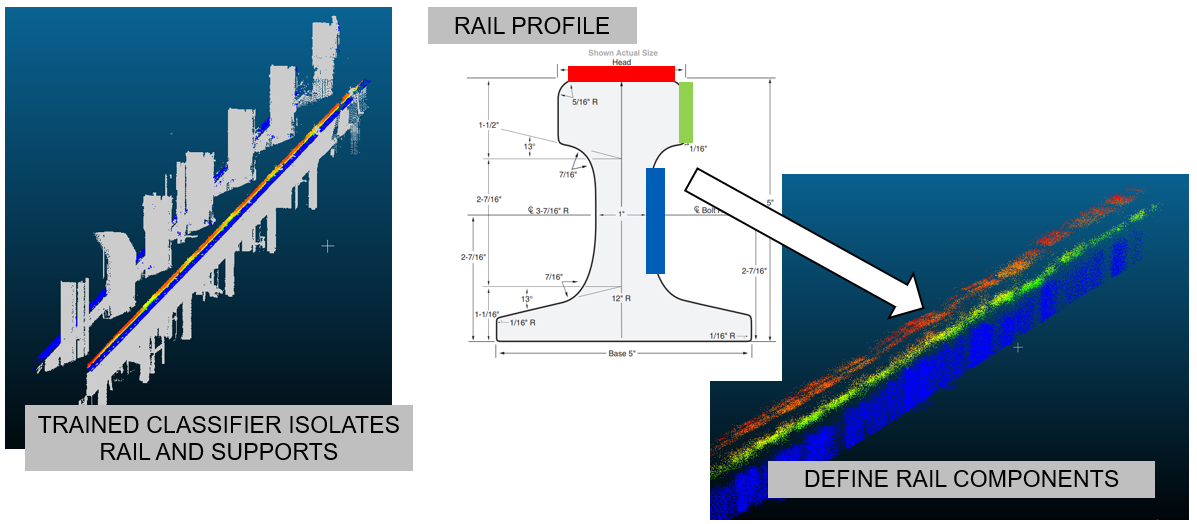

<br>
These surfaces can be captured by a 3D scanner moving along the rail’s axial direction (length of the rail). The lateral direction is perpendicular to the rails (the span between them), and the vertical direction is relative to the floor—corresponding to Y, X, and Z axes respectively.
Overhead crane rails are critical for crane movement in industrial facilities. They must be precisely aligned to prevent uneven wheel loading, premature wear, or structural issues. Tolerances are tight—typically between 3/16" and 1/4"—so even small deviations can cause operational problems.

#### Data Collection
A Leica BLK360 3D scanner was mounted on an indoor overhead bridge crane, about 10 ft from the rail. The crane moved in 12–20 ft increments, capturing scans from 6–7 positions per side. Due to obstructions on the north rail (later designated Rail B), the south rail was cropped to match its length.

A secondary objective is to determine whether the BLK360 provides sufficient point density and resolution for accurate rail capture or if a higher-performance scanner is needed. The isolated rail faces will be evaluated for compliance with CMAA (Crane Manufacturers Association of America) tolerances, focusing on elevation, straightness, and span deviations. Out-of-tolerance sections will receive recommended adjustments for realignment.

#### Why 3D Scanning?
Currently, rail alignment is measured using a total station, a survey instrument that records single points every 3–5 ft along the rail using a prism. This method is prone to human error (e.g., prism leveling) and accuracy drift—up to 1/8" every 500 ft. For rails as long as 2,000 ft, these errors accumulate significantly. Dense point clouds from 3D scanning eliminate these issues by providing thousands of points per foot, enabling best-fit curve analysis and reducing human bias.

#### Processing and Analysis
Point clouds are processed in CloudCompare, where rail profiles are cropped. Geometric features such as planarity, linearity, and sphericity are extracted using Principal Component Analysis (PCA). These features, trained on an ideal synthetic rail profile, feed a Random Forest model to classify rail components. While the model distinguishes between the rail head and web, unsupervised clustering is used to isolate the three target faces. Once isolated, these faces are ready for alignment evaluation.

This approach demonstrates that 3D scanning, combined with machine learning, can provide a more accurate, efficient, and automated method for crane rail alignment compared to traditional surveying techniques.
***

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
file_name = 'data/imported_data.csv'
df = pd.read_csv(file_name)

In [35]:
df

X          Y         Z   R    G    B  Intensity  \
0        9.439534  14.376236 -1.146688  41   46   49          4   
1        9.440045  14.074572 -1.174907  54   59   62          8   
2        9.443962  14.200837 -1.156712  46   51   54          6   
3        9.443726  14.381617 -1.186532  52   60   63         11   
4        9.419093  14.092623 -1.110571  58   64   64         12   
...           ...        ...       ...  ..  ...  ...        ...   
425418 -13.667930  -7.809042 -1.051000  64  202  122         24   
425419 -13.669897  -7.763073 -1.050626  64  202  122         20   
425420 -13.651345  -7.822357 -1.051755  64  202  122          8   
425421 -13.668946  -7.832104 -1.050694  64  202  122         22   
425422 -13.657827  -7.787619 -1.053248  64  202  122          6   

        Original_cloud_index  Illuminance_(PCV)  Classification        Nx  \
0                          0           0.648305             NaN -0.777440   
1                          0           0.533898             NaN -0.919458   
2                          0           0.504237             NaN -0.849193   
3                          0           0.572034             NaN -0.591658   
4                          0           0.885593             NaN -0.437266   
...                      ...                ...             ...       ...   
425418                     2           0.919492             NaN  0.195947   
425419                     2           0.995763             NaN  0.255349   
425420                     2           0.915254             NaN  0.232615   
425421                     2           0.927966             NaN  0.398272   
425422                     2           1.000000             NaN  0.193061   

              Ny        Nz  
0      -0.058486 -0.626232  
1       0.022171 -0.392563  
2      -0.031655 -0.527133  
3      -0.106645  0.799104  
4       0.001305  0.899331  
...          ...       ...  
425418  0.041564 -0.979733  
425419  0.043175 -0.965885  
425420 -0.136450 -0.962949  
425421 -0.011676 -0.917193  
425422  0.127445 -0.972875  

[425423 rows x 13 columns]

In [36]:
# convert from meters to feet and rename
df[['lateral', 'axial', 'vertical']] = df[['X', 'Y', 'Z']] * 3.28084

In [37]:
# set scales to start at zero
df['vertical'] = df['vertical'] - df['vertical'].min() # set min to 0
df['axial'] = df['axial'] - df['axial'].min() # set min to 0

In [38]:
drop_cols = ['X', 'Y', 'Z', 'R', 'B', 'G', 'Nx', 'Ny', 'Nz', 'Classification']
df = df.drop(columns=drop_cols)

In [39]:
df.rename(columns={'Illuminance_(PCV)': 'PCV'}, inplace=True) #keep this geometric feature. CloudCompare computes it very quickly compared to in the notebook.

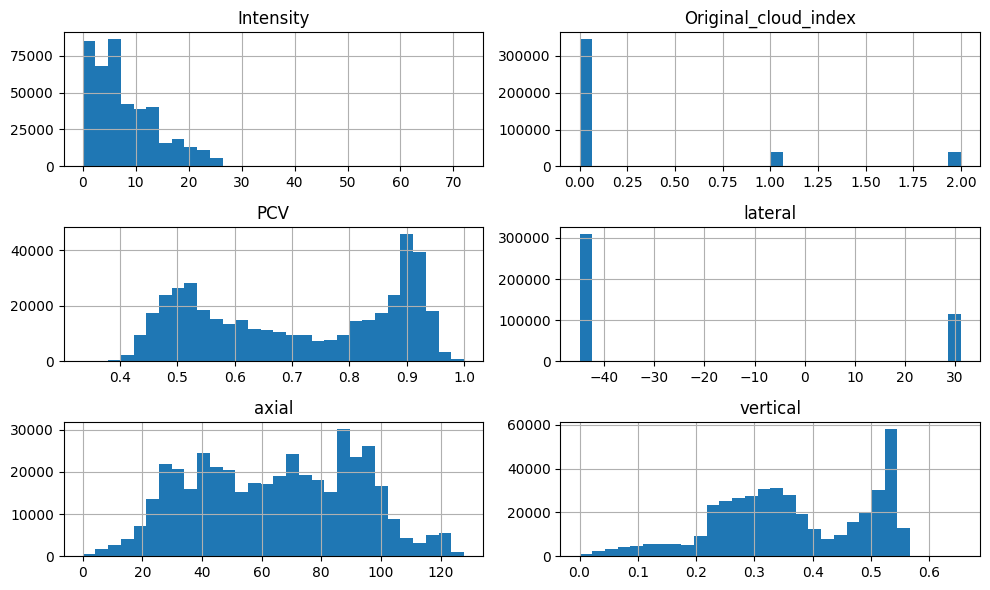

In [40]:
# Histograms for each column
df.hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

In [41]:
# convert and add inches columns
df[['lateral_inch', 'axial_inch', 'vertical_inch']] = df[['lateral', 'axial', 'vertical']] * 12 

In [42]:
# add round versions
df[['lateral_inch_round', 'axial_inch_round', 'vertical_inch_round']] = df[['lateral_inch', 'axial_inch', 'vertical_inch']].apply(
    lambda col: col.map(lambda x: round(x * 16) / 16))

In [43]:
#verify columns
df

Intensity  Original_cloud_index       PCV    lateral      axial  \
0               4                     0  0.648305  30.969601  73.969852   
1               8                     0  0.533898  30.971278  72.980139   
2               6                     0  0.504237  30.984129  73.394396   
3              11                     0  0.572034  30.983353  73.987505   
4              12                     0  0.885593  30.902538  73.039362   
...           ...                   ...       ...        ...        ...   
425418         24                     2  0.919492 -44.842290   1.183504   
425419         20                     2  0.995763 -44.848745   1.334321   
425420          8                     2  0.915254 -44.787880   1.139819   
425421         22                     2  0.927966 -44.845626   1.107842   
425422          6                     2  1.000000 -44.809146   1.253791   

        vertical  lateral_inch  axial_inch  vertical_inch  lateral_inch_round  \
0       0.207422    371.635216  887.638218       2.489062            371.6250   
1       0.114840    371.655341  875.761669       1.378078            371.6250   
2       0.174534    371.809543  880.732753       2.094413            371.8125   
3       0.076702    371.800232  887.850054       0.920427            371.8125   
4       0.325916    370.830450  876.472344       3.910989            370.8125   
...          ...           ...         ...            ...                 ...   
425418  0.521360   -538.107484   14.202051       6.256319           -538.1250   
425419  0.522586   -538.184942   16.011854       6.271028           -538.1875   
425420  0.518884   -537.454555   13.677830       6.226606           -537.4375   
425421  0.522365   -538.147508   13.294108       6.268381           -538.1250   
425422  0.513984   -537.709757   15.045489       6.167804           -537.6875   

        axial_inch_round  vertical_inch_round  
0               887.6250               2.5000  
1               875.7500               1.3750  
2               880.7500               2.1250  
3               887.8750               0.9375  
4               876.5000               3.9375  
...                  ...                  ...  
425418           14.1875               6.2500  
425419           16.0000               6.2500  
425420           13.6875               6.2500  
425421           13.3125               6.2500  
425422           15.0625               6.1875  

[425423 rows x 12 columns]

In [44]:
df.describe()

Intensity  Original_cloud_index            PCV        lateral  \
count  425423.000000         425423.000000  425423.000000  425423.000000   
mean        7.964567              0.276748       0.708961     -24.266292   
std         6.197848              0.620208       0.174922      33.646338   
min         0.000000              0.000000       0.334746     -44.925005   
25%         3.000000              0.000000       0.533898     -44.771256   
50%         6.000000              0.000000       0.707627     -44.740684   
75%        11.000000              0.000000       0.889831      30.923817   
max        72.000000              2.000000       1.000000      31.178737   

               axial       vertical   lateral_inch     axial_inch  \
count  425423.000000  425423.000000  425423.000000  425423.000000   
mean       64.641068       0.363633    -291.195504     775.692821   
std        27.313790       0.130202     403.756056     327.765481   
min         0.000000       0.000000    -539.100056       0.000000   
25%        41.092858       0.271056    -537.255072     493.114292   
50%        65.848360       0.350388    -536.888207     790.180322   
75%        87.952097       0.496063     371.085802    1055.425167   
max       127.864617       0.654076     374.144844    1534.375405   

       vertical_inch  lateral_inch_round  axial_inch_round  \
count  425423.000000       425423.000000     425423.000000   
mean        4.363595         -291.195583        775.692843   
std         1.562421          403.756108        327.765468   
min         0.000000         -539.125000          0.000000   
25%         3.252668         -537.250000        493.125000   
50%         4.204662         -536.875000        790.187500   
75%         5.952760          371.062500       1055.437500   
max         7.848909          374.125000       1534.375000   

       vertical_inch_round  
count        425423.000000  
mean              4.363623  
std               1.562531  
min               0.000000  
25%               3.250000  
50%               4.187500  
75%               5.937500  
max               7.875000

In [45]:
nan_counts_all = df.isna().sum()
nan_counts_all

Intensity               0
Original_cloud_index    0
PCV                     0
lateral                 0
axial                   0
vertical                0
lateral_inch            0
axial_inch              0
vertical_inch           0
lateral_inch_round      0
axial_inch_round        0
vertical_inch_round     0
dtype: int64

No missing values.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425423 entries, 0 to 425422
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Intensity             425423 non-null  int64  
 1   Original_cloud_index  425423 non-null  int64  
 2   PCV                   425423 non-null  float64
 3   lateral               425423 non-null  float64
 4   axial                 425423 non-null  float64
 5   vertical              425423 non-null  float64
 6   lateral_inch          425423 non-null  float64
 7   axial_inch            425423 non-null  float64
 8   vertical_inch         425423 non-null  float64
 9   lateral_inch_round    425423 non-null  float64
 10  axial_inch_round      425423 non-null  float64
 11  vertical_inch_round   425423 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 38.9 MB


All values are floats or integers.

#### Create distinction between left and right rail to rail 'a' and rail 'b'

In [47]:
# Create binary flags
df['is_rail_a'] = (df['lateral'] < 0).astype(int)  
df['is_rail_b'] = (df['lateral'] >= 0).astype(int)
df[['is_rail_a', 'is_rail_b']].sum()

is_rail_a    310339
is_rail_b    115084
dtype: int64

Rail 'a' has more points. See how they plot in a plan view (top view)

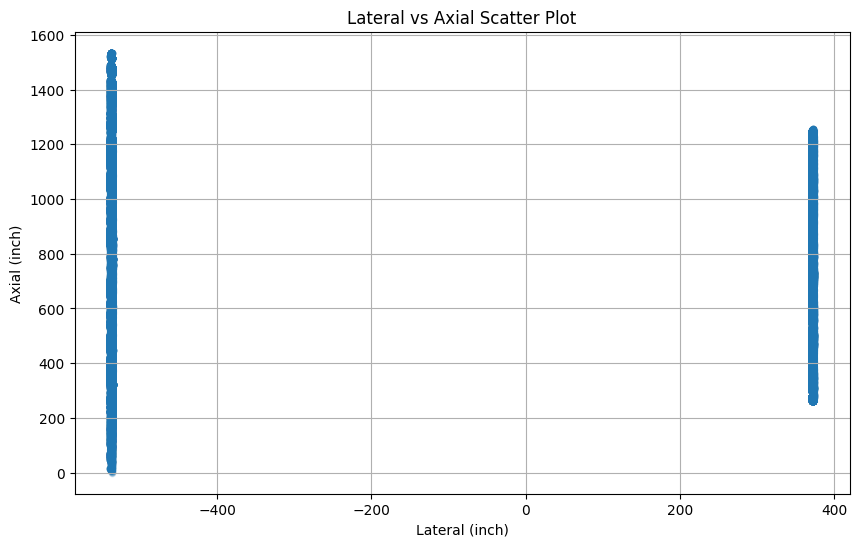

In [48]:
scatter = df.plot.scatter(x='lateral_inch', y='axial_inch', alpha=0.1, figsize=(10, 6))
plt.title('Lateral vs Axial Scatter Plot')
plt.xlabel('Lateral (inch)')
plt.ylabel('Axial (inch)')
plt.grid(True)
plt.show()

Rail 'a' had more points collected along its length. Truncate to match rail 'b'.

In [49]:
# Truncate left rail data to match right rail axial range

# Compute axial bounds for right rail
rmin, rmax = df.loc[df['is_rail_b'] == 1, 'axial_inch'].agg(['min', 'max'])

# Keep all non-left rows OR left rows within [rmin, rmax]
df = df[
    (df['is_rail_a'] == 0) | 
    df['axial_inch'].between(rmin, rmax, inclusive='both')
].copy()

print(f"Right rail axial range: [{rmin:.6f}, {rmax:.6f}]")
print(f"Rows after truncation: {len(df)}")

Right rail axial range: [260.230147, 1257.513605]
Rows after truncation: 384607


In [50]:
#check quantities of each rail after truncation
df[['is_rail_a', 'is_rail_b']].sum()

is_rail_a    269523
is_rail_b    115084
dtype: int64

#### After truncation rails are equal in length, more point quantities indicate rail 'a' has more surface area captured or is denser than rail 'b'.

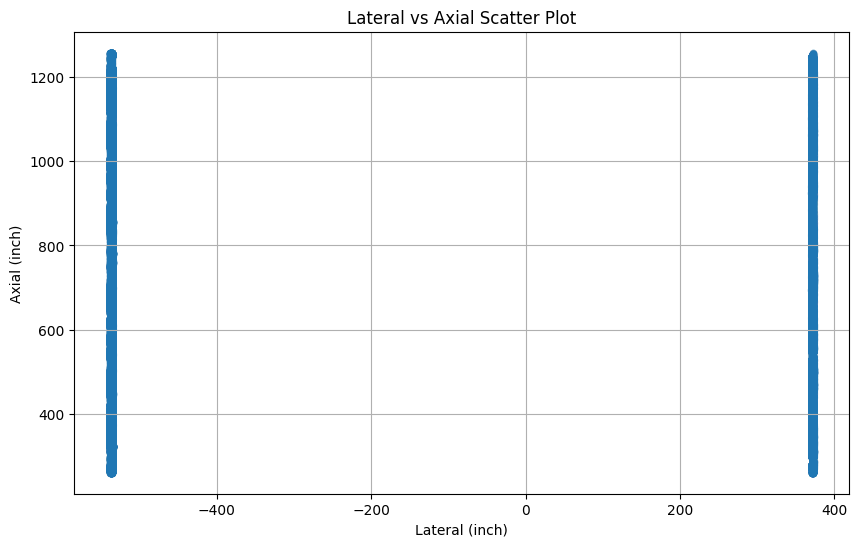

In [51]:
# truncated scatter plot, verify equal lengths
scatter = df.plot.scatter(x='lateral_inch', y='axial_inch', alpha=0.1, figsize=(10, 6))
plt.title('Lateral vs Axial Scatter Plot')
plt.xlabel('Lateral (inch)')
plt.ylabel('Axial (inch)')
plt.grid(True)
plt.show()

In [52]:

def rail_profiles_scatter_plot(df, x1='lateral_inch', y1='vertical_inch', x2='axial_inch', y2='lateral_inch'):
    # Split the dataframe into Rail A and Rail B
    dfa_temp = df[df['is_rail_a'] == 1]
    dfb_temp = df[df['is_rail_b'] == 1]

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Rail A Vertical Profile
    axs[0, 0].scatter(dfa_temp[x1], dfa_temp[y1], s=1, alpha=0.1)
    axs[0, 0].set_title('Rail A')
    axs[0, 0].set_xlabel(x1)
    axs[0, 0].set_ylabel(y1)
    axs[0, 0].grid(True)

    # Plot Rail A Axial Profile
    axs[0, 1].scatter(dfa_temp[x2], dfa_temp[y2], s=1, alpha=0.1)
    axs[0, 1].set_title('Rail A')
    axs[0, 1].set_xlabel(x2)
    axs[0, 1].set_ylabel(y2)
    axs[0, 1].grid(True)

    # Plot Rail B Vertical Profile
    axs[1, 0].scatter(dfb_temp[x1], dfb_temp[y1], s=1, alpha=0.1)
    axs[1, 0].set_title('Rail B')
    axs[1, 0].set_xlabel(x1)
    axs[1, 0].set_ylabel(y1)
    axs[1, 0].grid(True)

    # Plot Rail B Axial Profile
    axs[1, 1].scatter(dfb_temp[x2], dfb_temp[y2], s=1, alpha=0.1)
    axs[1, 1].set_title('Rail B')
    axs[1, 1].set_xlabel(x2)
    axs[1, 1].set_ylabel(y2)
    axs[1, 1].grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


#### Examine rail cross section and side view

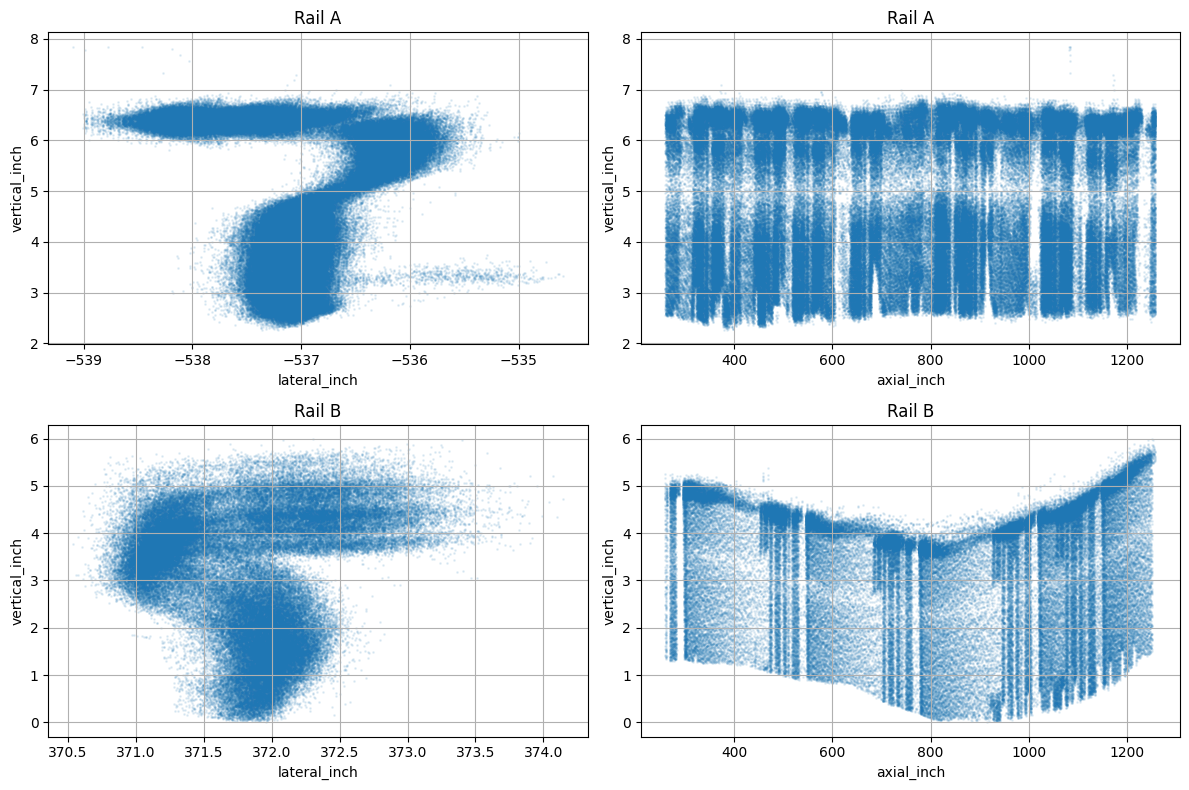

In [53]:
rail_profiles_scatter_plot(df, x1='lateral_inch', y1='vertical_inch', x2='axial_inch', y2='vertical_inch')

Rail 'b' has a curved shape along it's length. This will be evaluated by CMAA guidelines. This portion of the project needs to classify the components of the rails. Therefore, a relative vertical needs to be created so the rail top appears near flat. These will clarify the cross-sectional view too.

In [54]:
# Parameters for rolling quantile top curve
crown_band_in   = 0.35     # half-width of lateral crown band (in)
window_in       = 12.0    # axial window length for rolling quantile (in) ~ 10 ft
step_in         = 6.0     # stride between window centers (in)
q_top           = 0.99     # robust "top" inside the window (99th percentile)
min_pts_window  = 5       # require at least this many points in a window to accept it
smooth_win      = 7        # odd number; rolling-median smooth on the q99 curve

# Masks & lateral centers
maskL = df['is_rail_a'] == 1
maskR = df['is_rail_b'] == 1
if not maskL.any() or not maskR.any():
    raise ValueError("Need is_rail_a / is_rail_b flags precomputed.")

cenL = df.loc[maskL, 'lateral_inch'].median()
cenR = df.loc[maskR, 'lateral_inch'].median()

axmin, axmax = df['axial_inch'].min(), df['axial_inch'].max()
centers = np.arange(axmin + window_in/2, axmax - window_in/2 + 1e-9, step_in)

def rolling_top_curve(df, rail_mask, lateral_center):
    rows = []
    for cx in centers:
        wmask = (
            rail_mask
            & (df['axial_inch'] >= cx - window_in/2)
            & (df['axial_inch'] <  cx + window_in/2)
            & (np.abs(df['lateral_inch'] - lateral_center) <= crown_band_in)
        )
        if wmask.sum() < min_pts_window:
            continue
        qv = df.loc[wmask, 'vertical_inch'].quantile(q_top)
        rows.append((cx, qv))
    curve = pd.DataFrame(rows, columns=['cx', 'q'])
    if curve.empty:
        return curve
    # Smooth the top curve to reduce jitter from sampling
    if len(curve) >= smooth_win:
        curve['q_s'] = curve['q'].rolling(smooth_win, min_periods=1, center=True).median()
    else:
        curve['q_s'] = curve['q']
    return curve

# Build per-rail rolling top curves
curveL = rolling_top_curve(df, maskL, cenL)
curveR = rolling_top_curve(df, maskR, cenR)
if curveL.empty or curveR.empty:
    raise ValueError("Top curve could not be computed for one or both rails. Relax band, window, or min_pts_window.")

# Interpolate the reference (q99_smooth) to each point on its rail
refL = np.interp(df.loc[maskL, 'axial_inch'], curveL['cx'], curveL['q_s'])
refR = np.interp(df.loc[maskR, 'axial_inch'], curveR['cx'], curveR['q_s'])

# Create relative vertical by subtracting the local top curve (per rail)
df['vertical_inch_rel'] = df['vertical_inch']
df.loc[maskL, 'vertical_inch_rel'] -= refL
df.loc[maskR, 'vertical_inch_rel'] -= refR

# For non-rail points, subtract the average of both rail top curves at that axial
if (~(maskL | maskR)).any():
    # Interpolate both curves across all rows
    all_refL = np.interp(df['axial_inch'], curveL['cx'], curveL['q_s'])
    all_refR = np.interp(df['axial_inch'], curveR['cx'], curveR['q_s'])
    avg_ref = 0.5 * (all_refL + all_refR)
    df.loc[~(maskL | maskR), 'vertical_inch_rel'] = df.loc[~(maskL | maskR), 'vertical_inch'] - avg_ref

# Diagnostics: 99th percentile should be ~0 in crown bands
def residual_q(mask, center):
    use = mask & (np.abs(df['lateral_inch'] - center) <= crown_band_in)
    if use.sum() == 0:
        return np.nan
    return float(df.loc[use, 'vertical_inch_rel'].quantile(0.99))

rqL = residual_q(maskL, cenL)
rqR = residual_q(maskR, cenR)
print(f"Residual q{int(q_top*100)} in crown — left: {rqL:+.4f} in, right: {rqR:+.4f} in (should be near 0)")


Residual q99 in crown — left: +0.0038 in, right: +0.0036 in (should be near 0)


In [55]:
df

Intensity  Original_cloud_index       PCV    lateral       axial  \
0               4                     0  0.648305  30.969601   73.969852   
1               8                     0  0.533898  30.971278   72.980139   
2               6                     0  0.504237  30.984129   73.394396   
3              11                     0  0.572034  30.983353   73.987505   
4              12                     0  0.885593  30.902538   73.039362   
...           ...                   ...       ...        ...         ...   
425014          3                     2  0.889831 -44.816390  101.593367   
425015          7                     2  0.957627 -44.818952  102.850671   
425016          8                     2  0.906780 -44.825701  101.852361   
425017          1                     2  0.911017 -44.799569  101.856541   
425019          8                     2  0.970339 -44.822153  102.939237   

        vertical  lateral_inch   axial_inch  vertical_inch  \
0       0.207422    371.635216   887.638218       2.489062   
1       0.114840    371.655341   875.761669       1.378078   
2       0.174534    371.809543   880.732753       2.094413   
3       0.076702    371.800232   887.850054       0.920427   
4       0.325916    370.830450   876.472344       3.910989   
...          ...           ...          ...            ...   
425014  0.526926   -537.796676  1219.120403       6.323110   
425015  0.520461   -537.827426  1234.208056       6.245534   
425016  0.523527   -537.908414  1222.228330       6.282330   
425017  0.520309   -537.594827  1222.278491       6.243713   
425019  0.522580   -537.865836  1235.270840       6.270962   

        lateral_inch_round  axial_inch_round  vertical_inch_round  is_rail_a  \
0                 371.6250          887.6250               2.5000          0   
1                 371.6250          875.7500               1.3750          0   
2                 371.8125          880.7500               2.1250          0   
3                 371.8125          887.8750               0.9375          0   
4                 370.8125          876.5000               3.9375          0   
...                    ...               ...                  ...        ...   
425014           -537.8125         1219.1250               6.3125          1   
425015           -537.8125         1234.1875               6.2500          1   
425016           -537.9375         1222.2500               6.3125          1   
425017           -537.6250         1222.2500               6.2500          1   
425019           -537.8750         1235.2500               6.2500          1   

        is_rail_b  vertical_inch_rel  
0               1          -1.636106  
1               1          -2.724316  
2               1          -2.016024  
3               1          -3.205152  
4               1          -0.192049  
...           ...                ...  
425014          0          -0.281820  
425015          0          -0.330203  
425016          0          -0.322600  
425017          0          -0.361216  
425019          0          -0.304004  

[384607 rows x 15 columns]

Relative vertical correction was added. Examine how the cross-sections compare.

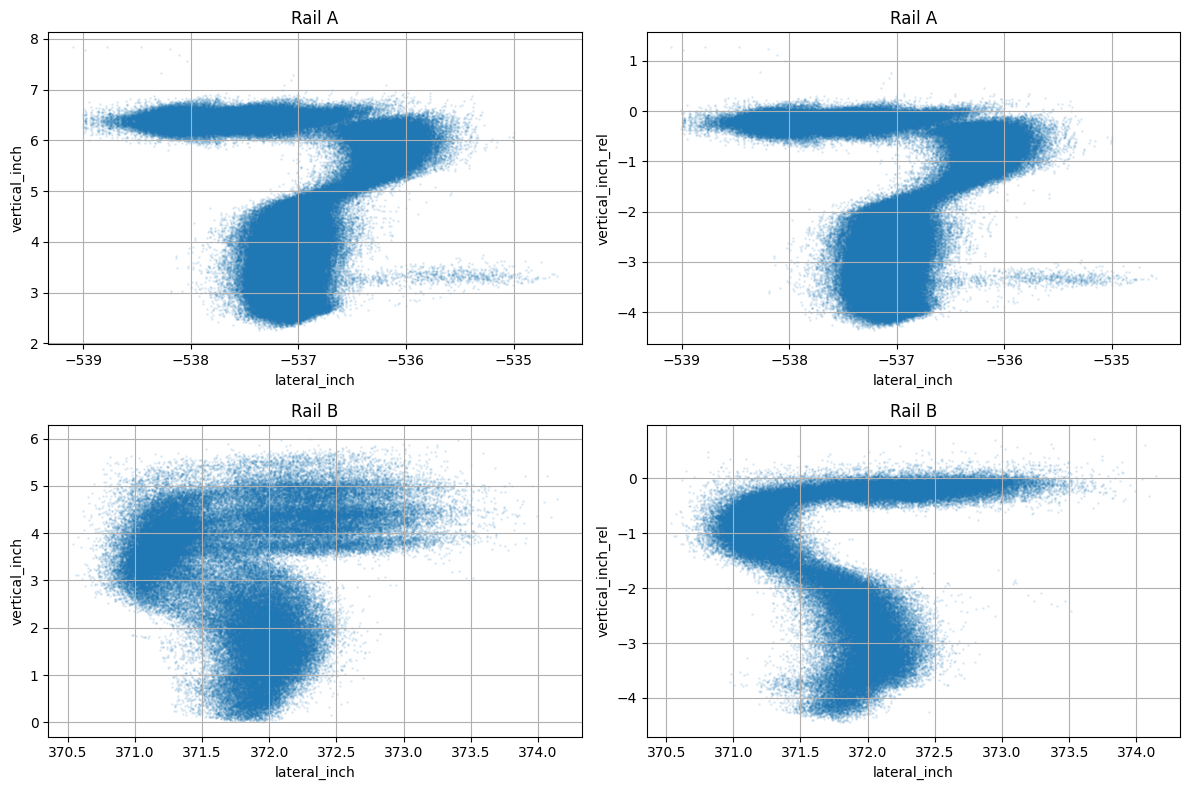

In [56]:
rail_profiles_scatter_plot(df, x1='lateral_inch', y1='vertical_inch', x2='lateral_inch', y2='vertical_inch_rel')

Profiles are more defined. See how the side view looks.

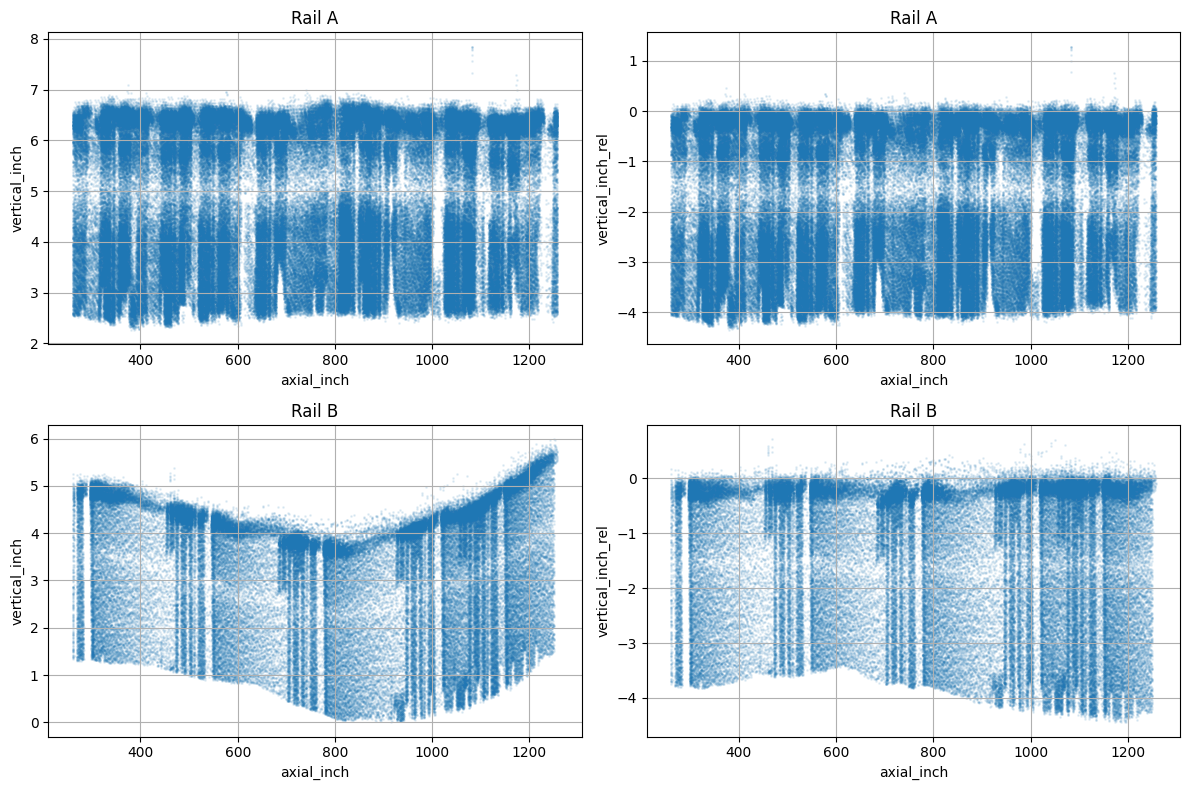

In [57]:
rail_profiles_scatter_plot(df, x1='axial_inch', y1='vertical_inch', x2='axial_inch', y2='vertical_inch_rel')

Much flatter along top of rail. Now lets straighten any lateral skewing with a relative lateral column.

In [58]:
# Parameters for rolling quantile side curve
side_band_in   = 0.25     # half-width of band (in)
window_in       = 12.0    # axial window length for rolling quantile (in) ~ 10 ft
step_in         = 6.0     # stride between window centers (in)
q_top           = 0.99     # robust "top" inside the window (99th percentile)
min_pts_window  = 5       # require at least this many points in a window to accept it
smooth_win      = 7        # odd number; rolling-median smooth on the q99 curve

# Masks & lateral centers
maskL = df['is_rail_a'] == 1
maskR = df['is_rail_b'] == 1

cenL = df.loc[maskL, 'vertical_inch_rel'].median()
cenR = df.loc[maskR, 'vertical_inch_rel'].median()

axmin, axmax = df['axial_inch'].min(), df['axial_inch'].max()
centers = np.arange(axmin + window_in/2, axmax - window_in/2 + 1e-9, step_in)

def rolling_top_curve(df, rail_mask, lateral_center):
    rows = []
    for cx in centers:
        wmask = (
            rail_mask
            & (df['axial_inch'] >= cx - window_in/2)
            & (df['axial_inch'] <  cx + window_in/2)
            & (np.abs(df['vertical_inch_rel'] - lateral_center) <= side_band_in)
        )
        if wmask.sum() < min_pts_window:
            continue
        qv = df.loc[wmask, 'lateral_inch'].quantile(q_top)
        rows.append((cx, qv))
    curve = pd.DataFrame(rows, columns=['cx', 'q'])
    if curve.empty:
        return curve
    # Smooth the top curve to reduce jitter from sampling
    if len(curve) >= smooth_win:
        curve['q_s'] = curve['q'].rolling(smooth_win, min_periods=1, center=True).median()
    else:
        curve['q_s'] = curve['q']
    return curve

# Build per-rail rolling top curves
curveL = rolling_top_curve(df, maskL, cenL)
curveR = rolling_top_curve(df, maskR, cenR)
if curveL.empty or curveR.empty:
    raise ValueError("Top curve could not be computed for one or both rails. Relax band, window, or min_pts_window.")

# Interpolate the reference (q99_smooth) to each point on its rail
refL = np.interp(df.loc[maskL, 'axial_inch'], curveL['cx'], curveL['q_s'])
refR = np.interp(df.loc[maskR, 'axial_inch'], curveR['cx'], curveR['q_s'])

# Create relative vertical by subtracting the local top curve (per rail)
df['lateral_inch_rel'] = df['lateral_inch']
df.loc[maskL, 'lateral_inch_rel'] -= refL
df.loc[maskR, 'lateral_inch_rel'] -= refR

# For non-rail points, subtract the average of both rail top curves at that axial
if (~(maskL | maskR)).any():
    # Interpolate both curves across all rows
    all_refL = np.interp(df['axial_inch'], curveL['cx'], curveL['q_s'])
    all_refR = np.interp(df['axial_inch'], curveR['cx'], curveR['q_s'])
    avg_ref = 0.5 * (all_refL + all_refR)
    df.loc[~(maskL | maskR), 'lateral_inch_rel'] = df.loc[~(maskL | maskR), 'lateral_inch'] - avg_ref

# Diagnostics: 99th percentile should be ~0 in crown bands
def residual_q(mask, center):
    use = mask & (np.abs(df['vertical_inch_rel'] - center) <= side_band_in)
    if use.sum() == 0:
        return np.nan
    return float(df.loc[use, 'lateral_inch_rel'].quantile(0.99))

rqL = residual_q(maskL, cenL)
rqR = residual_q(maskR, cenR)
print(f"Residual q{int(q_top*100)} in crown — left: {rqL:+.4f} in, right: {rqR:+.4f} in (should be near 0)")


Residual q99 in crown — left: +0.0445 in, right: +0.0192 in (should be near 0)


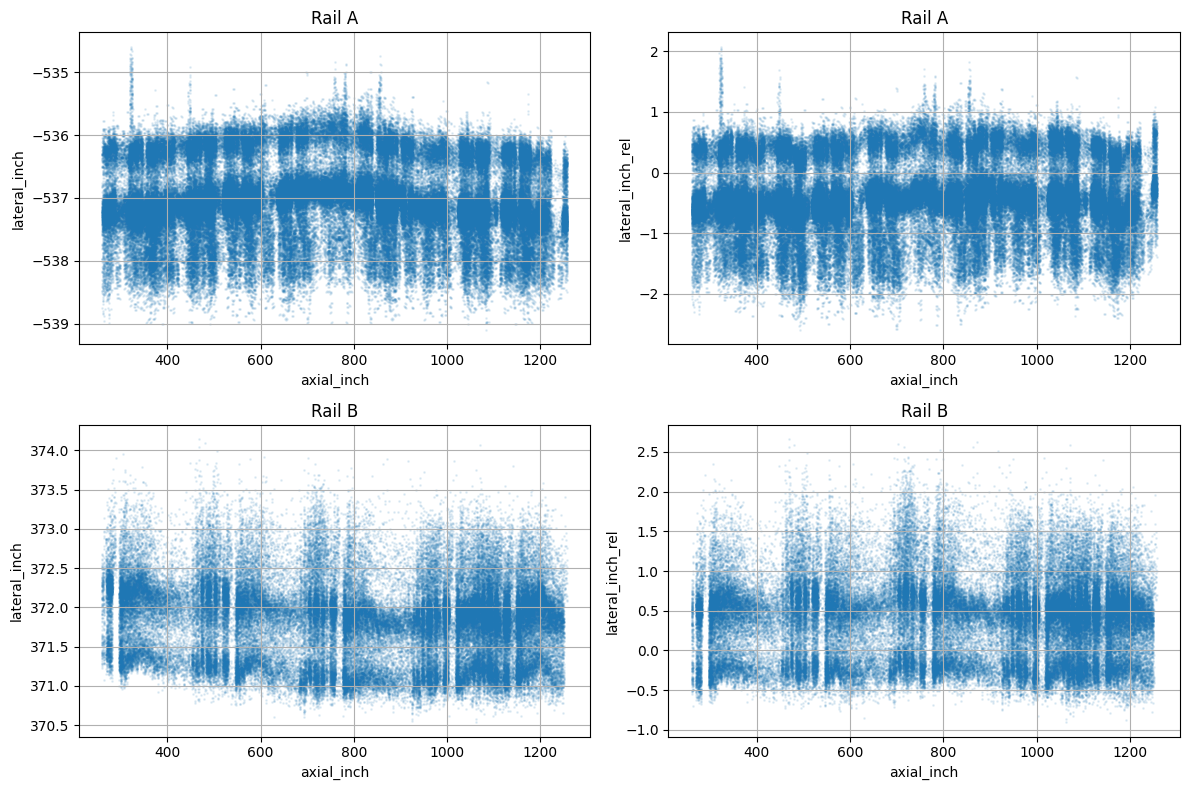

In [59]:
rail_profiles_scatter_plot(df, x1='axial_inch', y1='lateral_inch', x2='axial_inch', y2='lateral_inch_rel')

Laterally straighter after too.

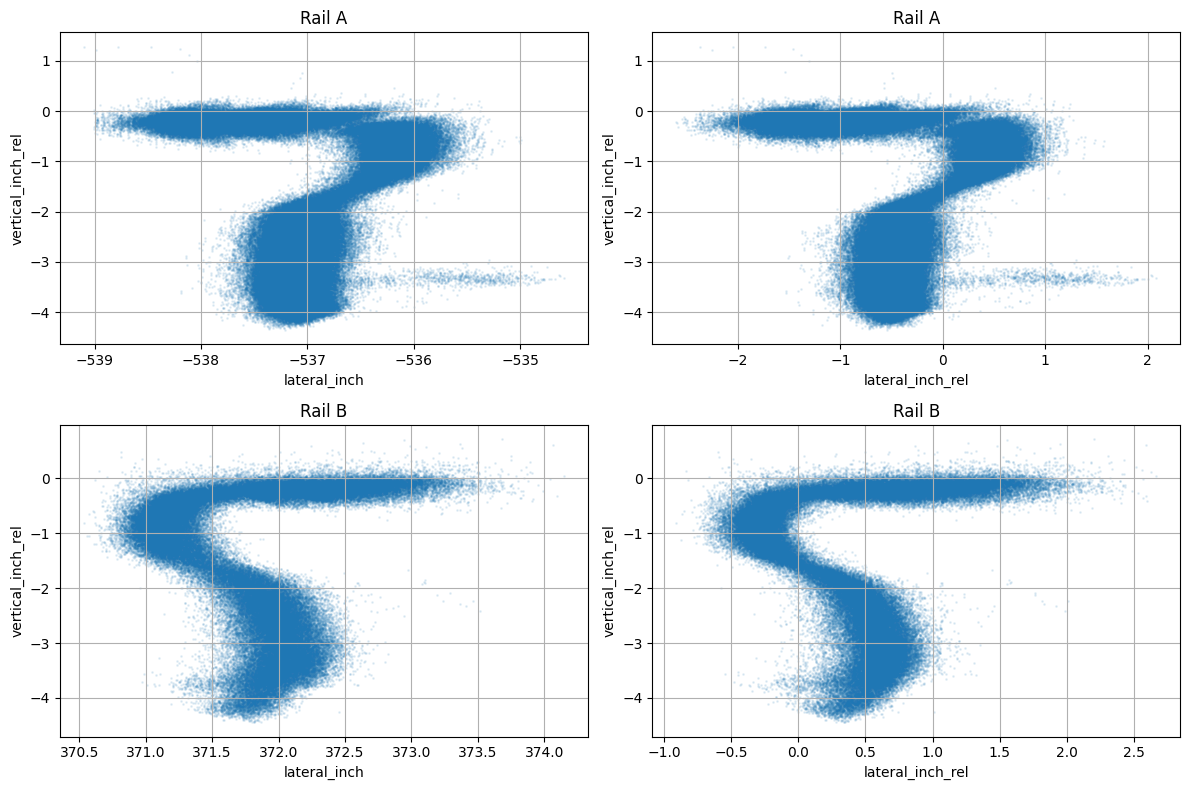

In [60]:
rail_profiles_scatter_plot(df, x1='lateral_inch', y1='vertical_inch_rel', x2='lateral_inch_rel', y2='vertical_inch_rel')

Cross-section shape is even more defined.

#### Missing data
When looking at the top or side views it is apparent that the scanner didn't collect point in certain sections creating the strips of empty space in the scatter plots. To aid in the classification of the faces filling these to increase neighboring points will help. The synthetically added points will be able to be removed prior to alignment evaluation but will remain in the rest of this process to help with classification.

In [61]:

def duplicate_shift(df, shift_in=1.0, axial_col='axial_inch'):
    """
    Duplicate all rows, shift axial by shift_in, and flag as synthetic.
    """
    dup = df.copy()
    dup[axial_col] = dup[axial_col] + shift_in
    dup['is_synth'] = 1
    return pd.concat([df, dup], ignore_index=True)

df_aug = duplicate_shift(df, shift_in=6.0)


In [62]:
df_aug

Intensity  Original_cloud_index       PCV    lateral       axial  \
0               4                     0  0.648305  30.969601   73.969852   
1               8                     0  0.533898  30.971278   72.980139   
2               6                     0  0.504237  30.984129   73.394396   
3              11                     0  0.572034  30.983353   73.987505   
4              12                     0  0.885593  30.902538   73.039362   
...           ...                   ...       ...        ...         ...   
769209          3                     2  0.889831 -44.816390  101.593367   
769210          7                     2  0.957627 -44.818952  102.850671   
769211          8                     2  0.906780 -44.825701  101.852361   
769212          1                     2  0.911017 -44.799569  101.856541   
769213          8                     2  0.970339 -44.822153  102.939237   

        vertical  lateral_inch   axial_inch  vertical_inch  \
0       0.207422    371.635216   887.638218       2.489062   
1       0.114840    371.655341   875.761669       1.378078   
2       0.174534    371.809543   880.732753       2.094413   
3       0.076702    371.800232   887.850054       0.920427   
4       0.325916    370.830450   876.472344       3.910989   
...          ...           ...          ...            ...   
769209  0.526926   -537.796676  1225.120403       6.323110   
769210  0.520461   -537.827426  1240.208056       6.245534   
769211  0.523527   -537.908414  1228.228330       6.282330   
769212  0.520309   -537.594827  1228.278491       6.243713   
769213  0.522580   -537.865836  1241.270840       6.270962   

        lateral_inch_round  axial_inch_round  vertical_inch_round  is_rail_a  \
0                 371.6250          887.6250               2.5000          0   
1                 371.6250          875.7500               1.3750          0   
2                 371.8125          880.7500               2.1250          0   
3                 371.8125          887.8750               0.9375          0   
4                 370.8125          876.5000               3.9375          0   
...                    ...               ...                  ...        ...   
769209           -537.8125         1219.1250               6.3125          1   
769210           -537.8125         1234.1875               6.2500          1   
769211           -537.9375         1222.2500               6.3125          1   
769212           -537.6250         1222.2500               6.2500          1   
769213           -537.8750         1235.2500               6.2500          1   

        is_rail_b  vertical_inch_rel  lateral_inch_rel  is_synth  
0               1          -1.636106          0.358831       NaN  
1               1          -2.724316          0.387008       NaN  
2               1          -2.016024          0.541040       NaN  
3               1          -3.205152          0.523372       NaN  
4               1          -0.192049         -0.437883       NaN  
...           ...                ...               ...       ...  
769209          0          -0.281820         -1.043377       1.0  
769210          0          -0.330203         -0.944458       1.0  
769211          0          -0.322600         -1.151885       1.0  
769212          0          -0.361216         -0.838298       1.0  
769213          0          -0.304004         -0.972244       1.0  

[769214 rows x 17 columns]

In [63]:
print(f"Original rows: {len(df)}, After augmentation: {len(df_aug)}")
print("Number of synthetic points added:", df_aug['is_synth'].sum())
print("Percent of synthetic points added:", 100 * df_aug['is_synth'].sum() / len(df_aug))

Original rows: 384607, After augmentation: 769214
Number of synthetic points added: 384607.0
Percent of synthetic points added: 50.0


Examine how the view changed. The first four are with out synthetic points and the second four plots are with the synthetic points.

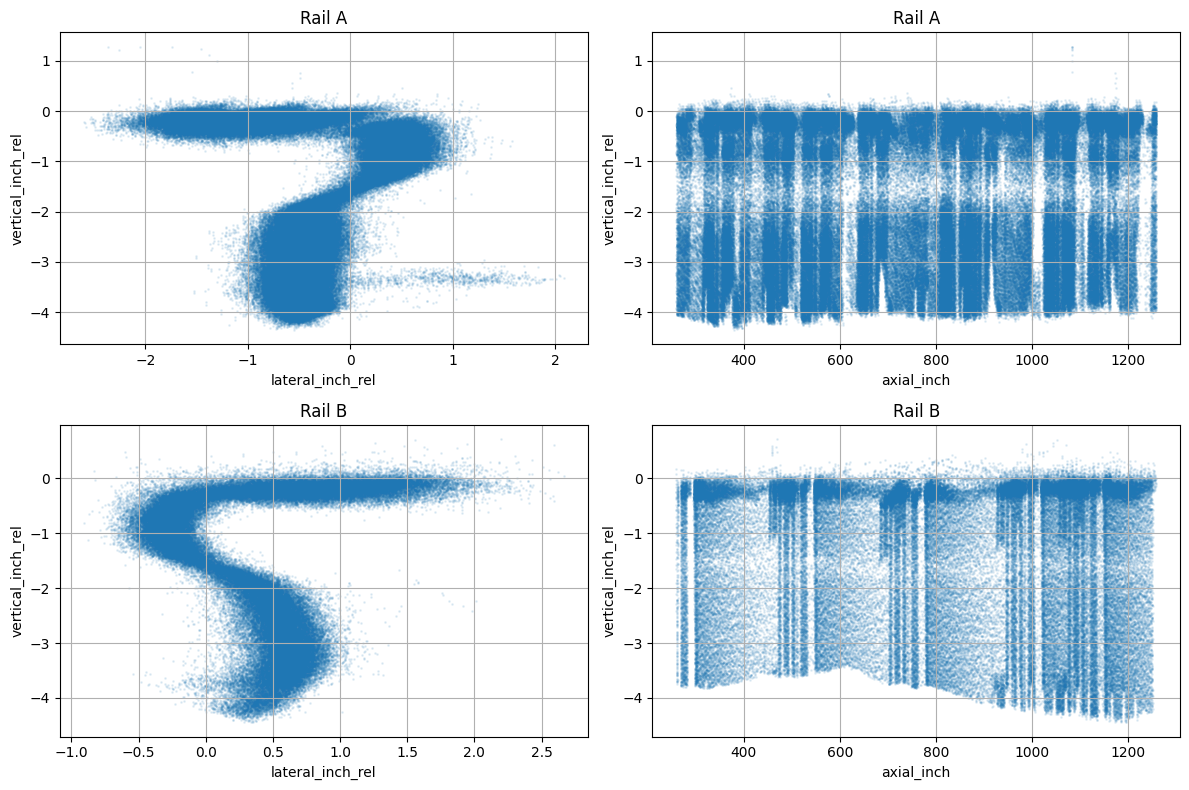

In [64]:
rail_profiles_scatter_plot(df, x1='lateral_inch_rel', y1='vertical_inch_rel', x2='axial_inch', y2='vertical_inch_rel')

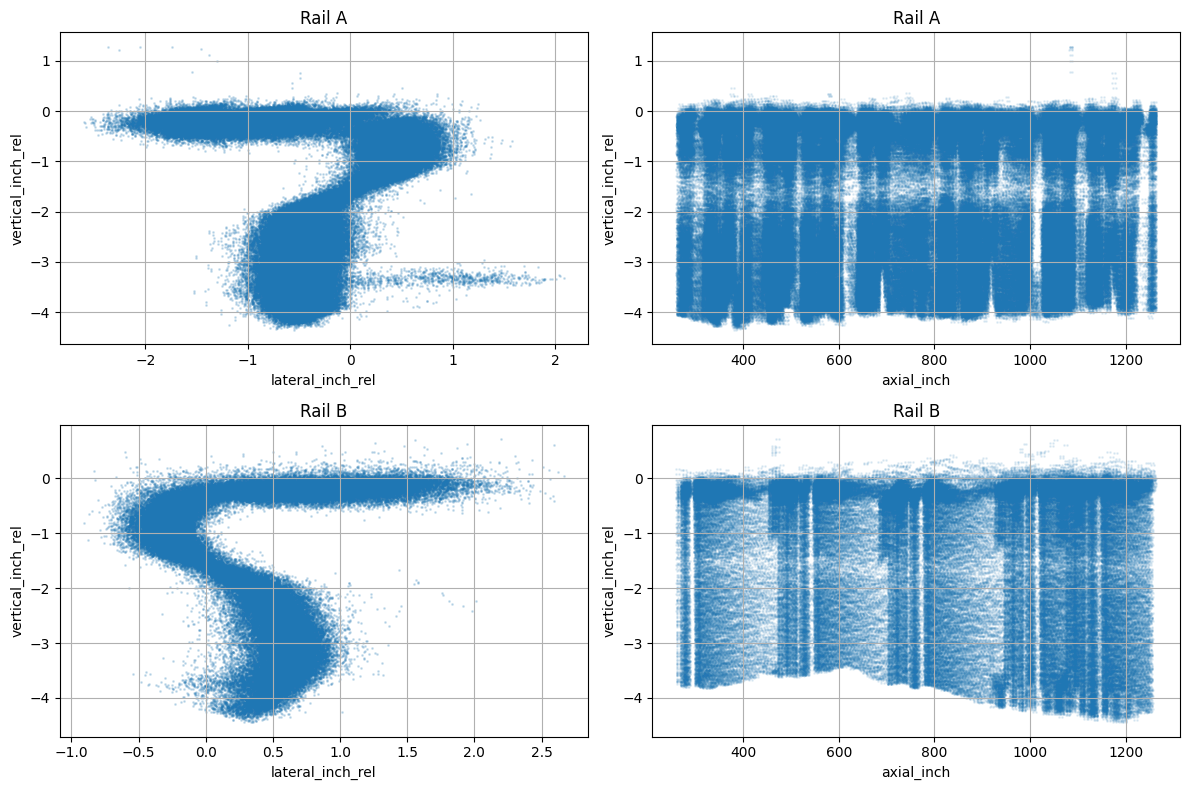

In [65]:
rail_profiles_scatter_plot(df_aug, x1='lateral_inch_rel', y1='vertical_inch_rel', x2='axial_inch', y2='vertical_inch_rel')

Sythetic points minimized the strips. Rename back to original df.

In [66]:
df = df_aug

In [67]:
df.rename(columns={'vertical_inch_rel': 'relative_vertical_inch'}, inplace=True)
df.rename(columns={'lateral_inch_rel': 'relative_lateral_inch'}, inplace=True)

In [68]:
df

Intensity  Original_cloud_index       PCV    lateral       axial  \
0               4                     0  0.648305  30.969601   73.969852   
1               8                     0  0.533898  30.971278   72.980139   
2               6                     0  0.504237  30.984129   73.394396   
3              11                     0  0.572034  30.983353   73.987505   
4              12                     0  0.885593  30.902538   73.039362   
...           ...                   ...       ...        ...         ...   
769209          3                     2  0.889831 -44.816390  101.593367   
769210          7                     2  0.957627 -44.818952  102.850671   
769211          8                     2  0.906780 -44.825701  101.852361   
769212          1                     2  0.911017 -44.799569  101.856541   
769213          8                     2  0.970339 -44.822153  102.939237   

        vertical  lateral_inch   axial_inch  vertical_inch  \
0       0.207422    371.635216   887.638218       2.489062   
1       0.114840    371.655341   875.761669       1.378078   
2       0.174534    371.809543   880.732753       2.094413   
3       0.076702    371.800232   887.850054       0.920427   
4       0.325916    370.830450   876.472344       3.910989   
...          ...           ...          ...            ...   
769209  0.526926   -537.796676  1225.120403       6.323110   
769210  0.520461   -537.827426  1240.208056       6.245534   
769211  0.523527   -537.908414  1228.228330       6.282330   
769212  0.520309   -537.594827  1228.278491       6.243713   
769213  0.522580   -537.865836  1241.270840       6.270962   

        lateral_inch_round  axial_inch_round  vertical_inch_round  is_rail_a  \
0                 371.6250          887.6250               2.5000          0   
1                 371.6250          875.7500               1.3750          0   
2                 371.8125          880.7500               2.1250          0   
3                 371.8125          887.8750               0.9375          0   
4                 370.8125          876.5000               3.9375          0   
...                    ...               ...                  ...        ...   
769209           -537.8125         1219.1250               6.3125          1   
769210           -537.8125         1234.1875               6.2500          1   
769211           -537.9375         1222.2500               6.3125          1   
769212           -537.6250         1222.2500               6.2500          1   
769213           -537.8750         1235.2500               6.2500          1   

        is_rail_b  relative_vertical_inch  relative_lateral_inch  is_synth  
0               1               -1.636106               0.358831       NaN  
1               1               -2.724316               0.387008       NaN  
2               1               -2.016024               0.541040       NaN  
3               1               -3.205152               0.523372       NaN  
4               1               -0.192049              -0.437883       NaN  
...           ...                     ...                    ...       ...  
769209          0               -0.281820              -1.043377       1.0  
769210          0               -0.330203              -0.944458       1.0  
769211          0               -0.322600              -1.151885       1.0  
769212          0               -0.361216              -0.838298       1.0  
769213          0               -0.304004              -0.972244       1.0  

[769214 rows x 17 columns]

In [69]:
df.describe()

Intensity  Original_cloud_index            PCV        lateral  \
count  769214.000000         769214.000000  769214.000000  769214.000000   
mean        8.069250              0.271833       0.701806     -22.089924   
std         6.295072              0.616582       0.175893      34.682066   
min         0.000000              0.000000       0.334746     -44.925005   
25%         3.000000              0.000000       0.525424     -44.766897   
50%         7.000000              0.000000       0.694915     -44.735565   
75%        12.000000              0.000000       0.885593      30.935863   
max        72.000000              2.000000       1.000000      31.178737   

               axial       vertical   lateral_inch     axial_inch  \
count  769214.000000  769214.000000  769214.000000  769214.000000   
mean       63.743903       0.357714    -265.079090     767.926837   
std        23.641162       0.130723     416.184793     283.709800   
min        21.685846       0.000000    -539.100056     260.230147   
25%        42.756992       0.266867    -537.202770     516.712691   
50%        65.090824       0.345267    -536.826782     784.424033   
75%        86.049213       0.488327     371.230355    1035.545778   
max       104.792800       0.654076     374.144844    1263.513605   

       vertical_inch  lateral_inch_round  axial_inch_round  \
count  769214.000000       769214.000000     769214.000000   
mean        4.292572         -265.079169        764.926868   
std         1.568671          416.184849        283.693943   
min         0.000000         -539.125000        260.250000   
25%         3.202405         -537.187500        513.062500   
50%         4.143208         -536.812500        781.062500   
75%         5.859929          371.250000       1032.562500   
max         7.848909          374.125000       1257.500000   

       vertical_inch_round      is_rail_a      is_rail_b  \
count        769214.000000  769214.000000  769214.000000   
mean              4.292601       0.700775       0.299225   
std               1.568765       0.457919       0.457919   
min               0.000000       0.000000       0.000000   
25%               3.187500       0.000000       0.000000   
50%               4.125000       1.000000       0.000000   
75%               5.875000       1.000000       1.000000   
max               7.875000       1.000000       1.000000   

       relative_vertical_inch  relative_lateral_inch  is_synth  
count           769214.000000          769214.000000  384607.0  
mean                -1.711971              -0.173881       1.0  
std                  1.350679               0.671781       0.0  
min                 -4.446544              -2.600929       1.0  
25%                 -2.966308              -0.569225       1.0  
50%                 -1.558085              -0.299249       1.0  
75%                 -0.336211               0.390402       1.0  
max                  1.287359               2.663073       1.0

#### Data has been fully cleaned, scaled, shifted, and transformed.

In [70]:
df.to_csv('data/df_processed.csv', index=False)